---
## PEA model simulation (based on single trial learning model from Zhang et al 2024)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import integrate
from scipy.stats import norm
from scipy.special import logsumexp
from statsmodels.nonparametric.smoothers_lowess import lowess

%config InlineBackend.figure_format = "retina"

In [2]:
# Simulated parameters
pert_size = np.array([ -4, -2, 0, 2, 4])
# pert_size = np.array([0])
n_per_pert = 100
n_per_miniblock = 3
num_trials = len(pert_size) * n_per_pert * n_per_miniblock + 1  # must add one to get correct number of adaptation measures using triplet method
perts = np.repeat(pert_size, n_per_pert)
perts = np.random.permutation(perts)
delta_x = np.zeros(num_trials)
delta_x[1::n_per_miniblock] = perts

sigma_motor = 2
eps = np.random.normal(loc=0, scale=sigma_motor, size=num_trials)  # motor noise

In [3]:
x_stl = np.zeros(num_trials)
x_hand = np.zeros(num_trials)
x_ige_learner = np.zeros(num_trials)
T = 0
B = 0.5
sigma_int = 7.364

selective_learning = False

# Loop through trials
for i in range(num_trials - 1):
    if i==0:
        x_hand[i] = eps[i]
        x_ige_learner[i] = eps[i]
    x_v = x_hand[i] + delta_x[i]   
    sigma_v = 1.179 + 0.384 * np.abs(x_v)  # after Zhang et al
    w_int = (1 / sigma_int**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
    w_v = (1 / sigma_v**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
    xhat_hand = w_v * x_v
    x_stl[i] = B * (T - xhat_hand)
    
    vis_err = x_ige_learner[i] + delta_x[i]
    if selective_learning:
        if (i % n_per_miniblock == 1) | (i % n_per_miniblock == 2):
            x_hand[i + 1] = x_stl[i] + eps[i + 1]
            x_ige_learner[i + 1] = B * (T - vis_err) + eps[i + 1]
        else:
            x_hand[i + 1] = eps[i + 1]
            x_ige_learner[i + 1] = eps[i + 1]
    else:
        x_hand[i + 1] = x_stl[i] + eps[i + 1]
        x_ige_learner[i + 1] = B * (T - vis_err) + eps[i + 1]
    # x_hand[i + 1] = x_stl[i] + eps[i + 1]
    # x_ige_learner[i + 1] = B * (T - vis_err) + eps[i + 1]

 

In [4]:
# Adaptation quantified as difference in hand angle post- and pre-perturbation
adaptation_pea = np.zeros(num_trials)
adaptation_pea[1::n_per_miniblock] = x_hand[2::n_per_miniblock] - x_hand[0:-1:n_per_miniblock]

adapt_ige = np.zeros(num_trials)
adapt_ige[1::n_per_miniblock] = x_ige_learner[2::n_per_miniblock] - x_ige_learner[0:-1:n_per_miniblock]

# Create data frame with all trials
df_pea = pd.DataFrame({
    "x_hand":x_hand, "x_ige_learner":x_ige_learner, "x_stl":x_stl, "eps":eps,
    "delta_x":delta_x, "adaptation_pea":adaptation_pea, "adapt_ige":adapt_ige
})
df_pea.sample(10)

,x_hand,x_ige_learner,x_stl,eps,delta_x,adaptation_pea,adapt_ige
346,-5.606421,-5.782883,0.758123,-4.534926,4.0,-6.260200,-6.311011
301,1.502152,1.774036,0.240595,-0.170478,-2.0,3.546664,3.537082
193,-0.229051,-0.249125,1.035455,0.349029,-2.0,-1.134654,-1.027993
615,-0.078462,-0.156140,0.038201,-0.880566,0.0,0.000000,0.000000
736,-1.905145,-3.039675,-0.976582,0.527038,4.0,-8.011312,-8.710672
561,-2.529211,-2.910008,1.165258,-1.661127,0.0,0.000000,0.000000
1170,4.767319,5.291338,-2.042494,2.778504,0.0,0.000000,0.000000
151,7.234728,7.546359,-2.204002,5.291581,-2.0,5.800406,5.250412
108,2.758681,2.425652,-1.262682,3.942591,0.0,0.000000,0.000000
1062,0.826599,0.800601,-0.396910,1.205862,0.0,0.000000,0.000000


In [5]:
# Create trimmed data frame without null trials
pea = df_pea.iloc[1::n_per_miniblock].reset_index()
pea.head()

,index,x_hand,x_ige_learner,x_stl,eps,delta_x,adaptation_pea,adapt_ige
0,1,-2.694971,-2.716818,2.658209,-2.212201,-4.0,-0.390640,0.309560
1,4,2.173323,2.444811,0.857428,1.059668,-4.0,2.557727,2.839029
2,7,-2.117242,-2.188446,0.057045,-1.291855,2.0,1.753021,1.752318
3,10,5.245232,5.548870,-2.207542,3.611162,0.0,2.676166,2.312559
4,13,-1.418646,-1.620663,0.672476,-0.617713,0.0,1.232805,1.065788


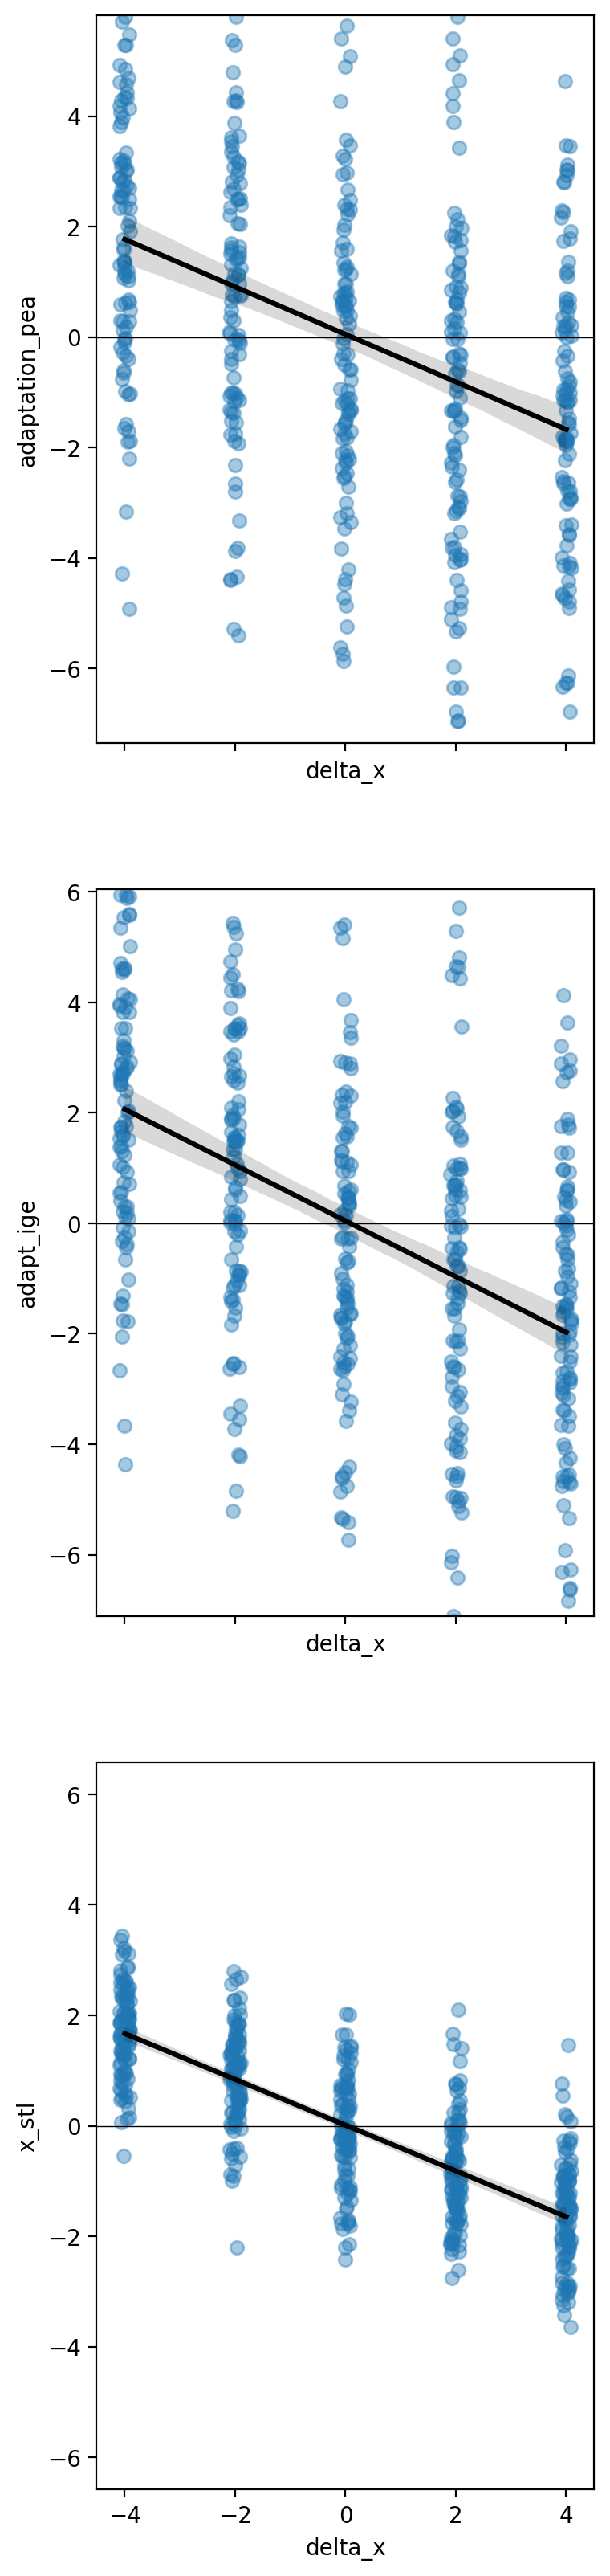

In [6]:
# Plot adaptation to external errors (lowess=True for 'piecewise' fit)
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(4, 20))
sns.regplot(data=pea, x="delta_x", x_jitter=0.1, y="adaptation_pea", 
               scatter_kws={"alpha":0.4}, line_kws={"color":"k"}, ax=axs[0])
axs[0].axis("equal")
axs[0].set(yticks=np.arange(-10, 10.01, 2))
axs[0].axhline(color="k", linewidth=0.5)

sns.regplot(data=pea, x="delta_x", x_jitter=0.1, y="adapt_ige", 
               scatter_kws={"alpha":0.4}, line_kws={"color":"k"}, ax=axs[1])
axs[1].axis("equal")
axs[1].set(yticks=np.arange(-10, 10.01, 2))
axs[1].axhline(color="k", linewidth=0.5)

sns.regplot(data=pea, x="delta_x", x_jitter=0.1, y="x_stl", 
               scatter_kws={"alpha":0.4}, line_kws={"color":"k"}, ax=axs[2])
axs[2].axis("equal")
axs[2].set(yticks=np.arange(-10, 10.01, 2))
axs[2].axhline(color="k", linewidth=0.5)
plt.show()

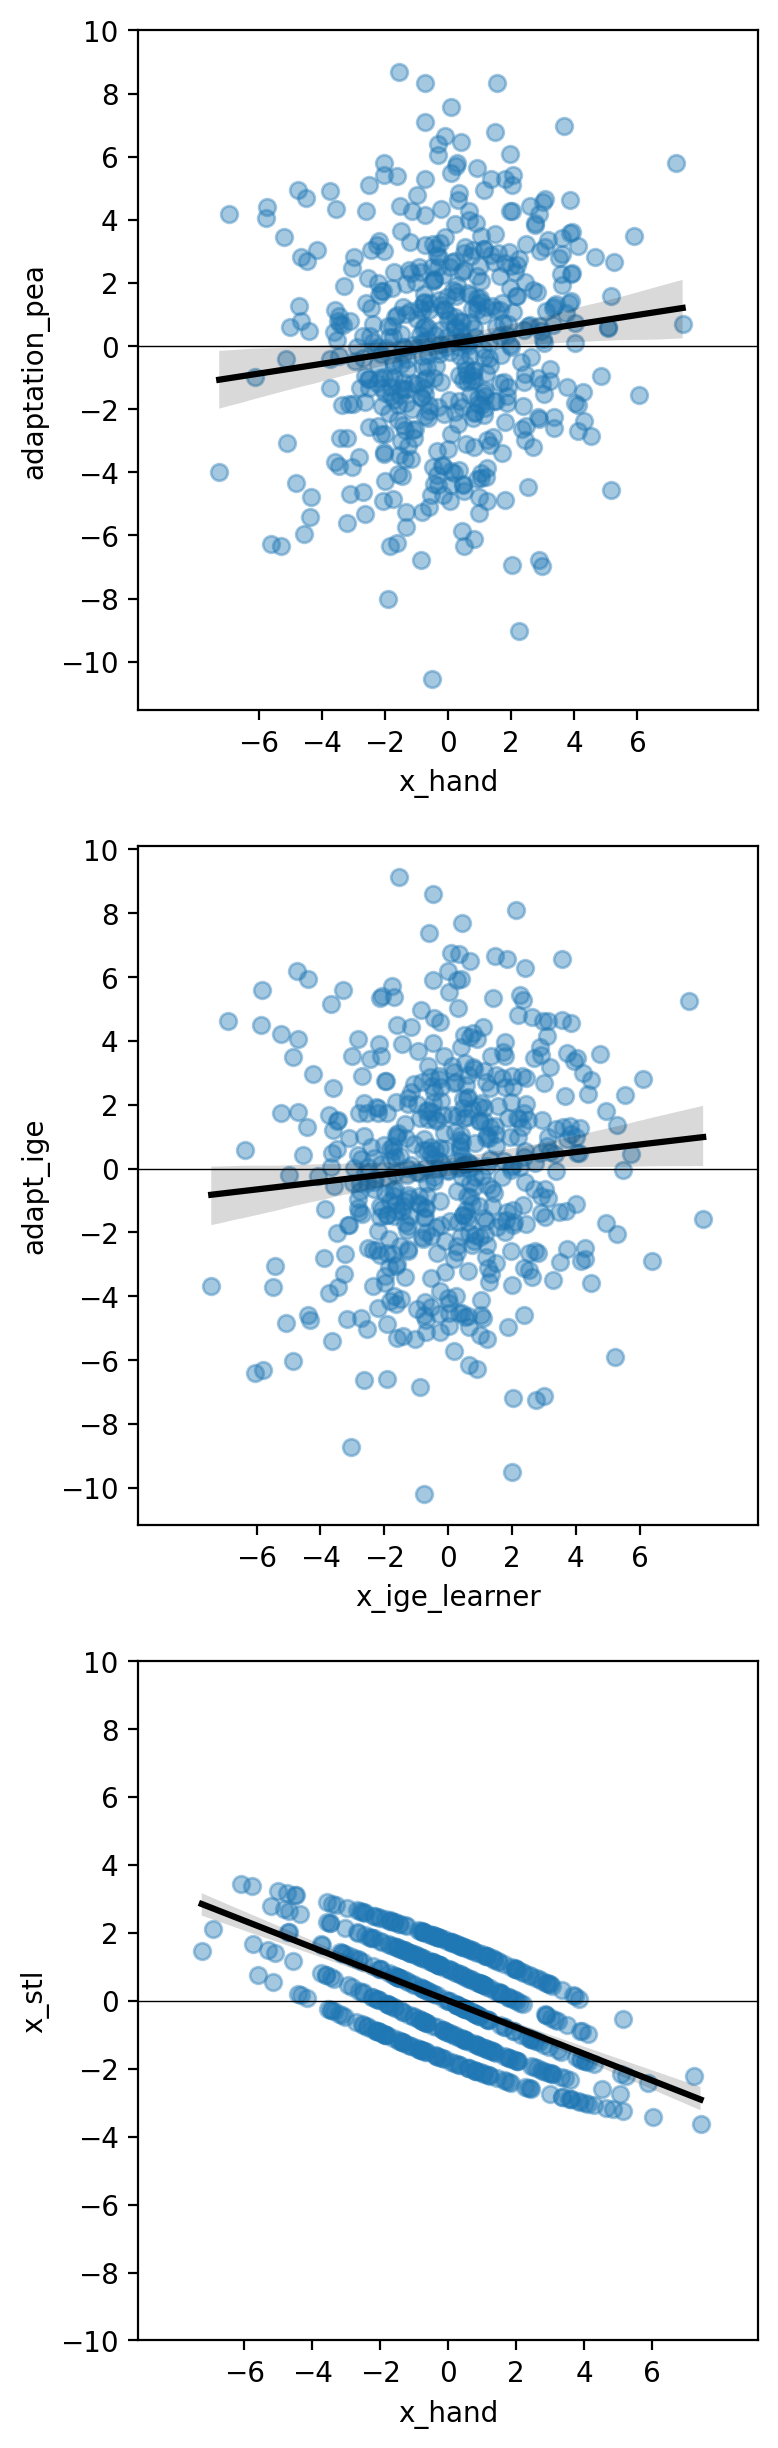

In [7]:
# Plot adaptation to internally-generated errors
fig, axs = plt.subplots(3, 1, figsize=(4, 15))
sns.regplot(data=pea, x="x_hand", y="adaptation_pea", line_kws={"color":"k"}, scatter_kws={"alpha":0.4}, ax=axs[0])
axs[0].axis("equal")
axs[0].set(xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), yticks=np.arange(-10, 10.01, 2))
axs[0].axhline(color="k", linewidth=0.5)

sns.regplot(data=pea, x="x_ige_learner", y="adapt_ige", line_kws={"color":"k"}, scatter_kws={"alpha":0.4}, ax=axs[1])
axs[1].axis("equal")
axs[1].set(xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), yticks=np.arange(-10, 10.01, 2))
axs[1].axhline(color="k", linewidth=0.5)

sns.regplot(data=pea, x="x_hand", y="x_stl", line_kws={"color":"k"}, scatter_kws={"alpha":0.4}, ax=axs[2])
axs[2].axis("equal")
axs[2].set(xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), yticks=np.arange(-10, 10.01, 2))
axs[2].axhline(color="k", linewidth=0.5)
plt.show()

(500,)


<Axes: >

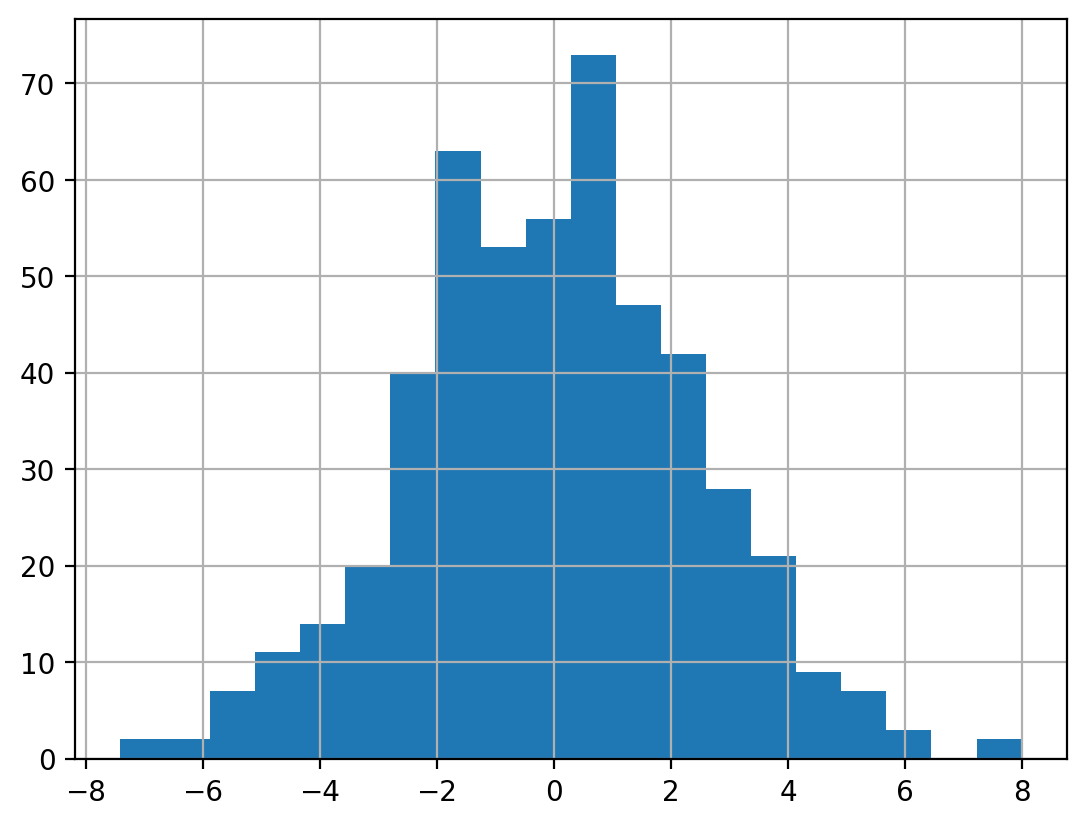

In [8]:
print(pea["x_ige_learner"].shape)
pea["x_ige_learner"].hist(bins=20)

In [9]:
# Process data to create 5x5 IGE/EGE plots. Binning based on IGE.
pea["ige_quintile"] = pea.groupby(["delta_x"])["x_hand"].transform(
    lambda x: pd.qcut(x, 5, labels=range(1, 6)))
pea_binned = pea.groupby(["delta_x", "ige_quintile"])[["x_hand", "adaptation_pea"]].mean().reset_index()

/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_19701/1973501759.py:25: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=pea_binned, x="delta_x", y="adaptation_pea", hue="ige_quintile", join=True, ax=ax2)


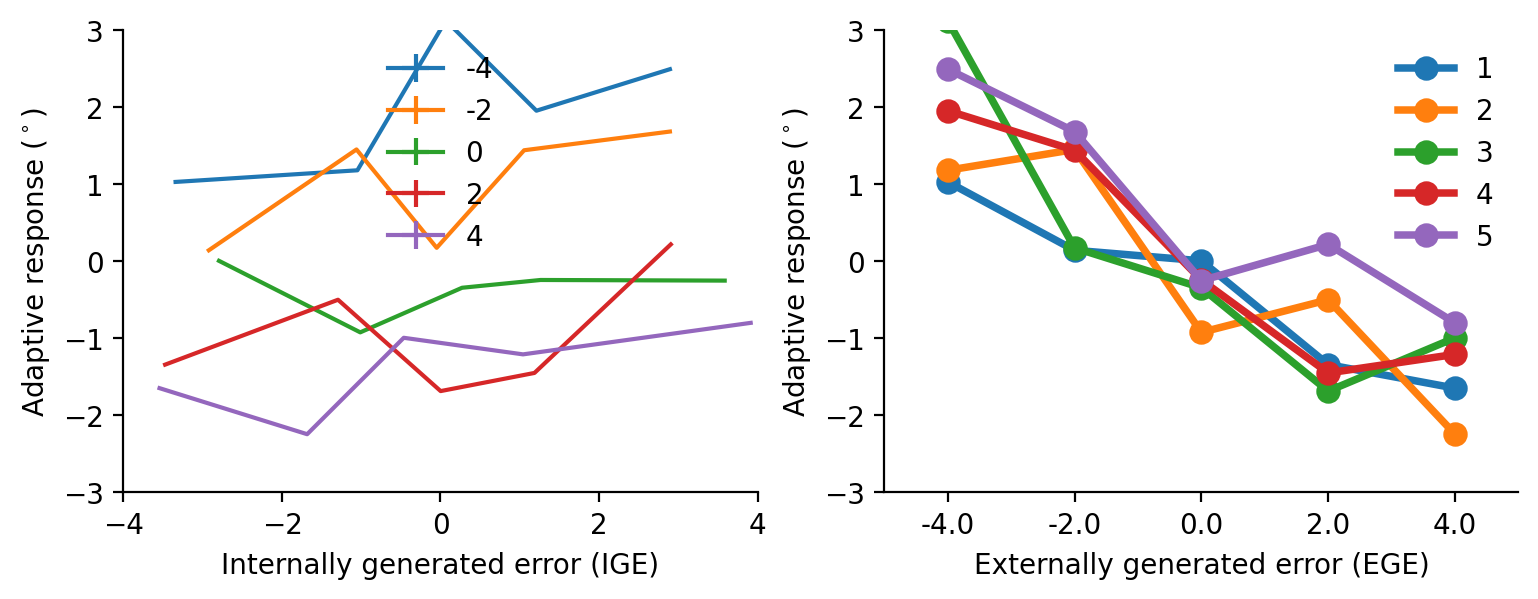

In [10]:
# Plot adaptive response vs IGE and EGE for rotation trials
rotations = np.unique(perts)
pert = []
x_mean_ige = np.zeros(5)
x_err_ige = np.zeros(5)
y_mean_ige = np.zeros(5)
y_err_ige = np.zeros(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
for i in range(len(rotations)):
    idx = pea_binned["delta_x"] == rotations[i]
    pert = pd.DataFrame(pea_binned.loc[idx, :])
    for j in range(5):
        idx_bin = pert["ige_quintile"] == j + 1
        x_mean_ige[j] = pert.loc[idx_bin, "x_hand"].mean()
        x_err_ige[j] = pert.loc[idx_bin, "x_hand"].sem()
        y_mean_ige[j] = pert.loc[idx_bin, "adaptation_pea"].mean()
        y_err_ige[j] = pert.loc[idx_bin, "adaptation_pea"].sem()
    ax1.errorbar(x_mean_ige, y_mean_ige, x_err_ige, y_err_ige, label=rotations[i])
ax1.legend(frameon=False)
ax1.set(xlabel="Internally generated error (IGE)", ylabel="Adaptive response ($^\circ$)", xlim=[-4, 4], ylim=[-3, 3])
sns.despine()

# Plot adaptive response as a function of EGE
sns.pointplot(data=pea_binned, x="delta_x", y="adaptation_pea", hue="ige_quintile", join=True, ax=ax2)
ax2.set(xlabel="Externally generated error (EGE)", ylim=[-3, 3], ylabel="Adaptive response ($^\circ$)")
ax2.legend(frameon=False)
plt.show()